In [1]:
import numpy as np
import h5py
import os
from scipy.io import netcdf_file as netcdf
from scipy.interpolate import griddata
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
%matplotlib inline

# Generate topography and diffusivity input files

In [12]:
plotting = True

# Parameters
ridge = True
kbg = 5.e-4 # Background mixing (2.5e-5 m^2/s)
kslope = 5.e-3 # Maximum mixing over continental slope (2.5e-4 m^2/s)
ktype = "bottom"

more_strats = ['del-0.1','del-0.3','del-0.5','del-1.0','del-2.0','del-4.0']
strats_kridges = ['del-inf', 'del-0.4']
kridges = ['0.025','0.041', '0.066', '0.107', '0.175', '0.284', '0.461', '0.750']
ridgeh = 0.6

# More stratification experiments

Created ../pgcm/ridge-0.6_del-0.1
Created ../pgcm/ridge-0.6_del-0.3
Created ../pgcm/ridge-0.6_del-0.5
Created ../pgcm/ridge-0.6_del-1.0
Created ../pgcm/ridge-0.6_del-2.0
Created ../pgcm/ridge-0.6_del-4.0


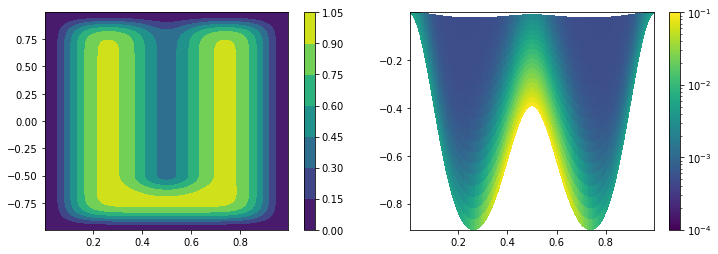

In [13]:
kridge = 1.e-1 # Maximum mixing over ridge (5.e-3 m^2/s)

for strat in more_strats:
    exp_name = "../pgcm/ridge-"+str(ridgeh)+"_"+strat

    # spacing
    dx = 0.01; dy = 0.01; ds = 0.05;

    # node grid (with 1-grid point buffer on all sides)
    x = np.arange(0.,1.+dx,dx)
    y = np.arange(-1.,1.+dy,dy)

    # (ny+1, nx+1)
    x,y = np.meshgrid(x,y)

    # grid size (incl. buffer)
    nyb = np.shape(x)[0]
    nxb = np.shape(x)[1]

    # non-dim width of gaussian bumps
    d=0.1;

    # gaussian with max height the full depth of the domain
    def g(x): return (1-np.exp(-x**2/(2*d**2)));

    # gaussian with max height half the full depth of the domain
    def gsmall(x,y):
        a=np.zeros_like(x)
        a[y<=-0.5]= np.sqrt((x[y<=-0.5]-0.5)**2+(y[y<=-0.5]+0.5)**2)
        a[y>-0.5] = np.sqrt((x[y>-0.5]-0.5)**2)
        return (1-ridgeh*np.exp(-a**2/(2*d**2)));

    def smoothstep(x,x0,x1,y0,y1):
        tmp = np.zeros_like(x)
        idx = np.logical_and(x>=x0,x<=x1)
        tmp[idx] = 3.*((x[idx]-x0[idx])/(x1[idx]-x0[idx]))**2 - 2.*((x[idx]-x0[idx])/(x1[idx]-x0[idx]))**3
        tmp[x>=x1] = 1.
        return tmp*(y1-y0)+y0

    if ridge:
        h = g(x-np.max(x))*g(x-np.min(x))*g(y-np.min(y))*g(y-np.max(y))*gsmall(x,y)
        h[h<0] = 0

    if not ridge:
        h = g(x)*g(1-x)*g(1+y)*g(1-y)

    # Interpolate depth from cell center to faces and nodes

    # (ny,nx+1)
    xfx = (x[:-1,:]+x[1:,:])/2.
    yfx = (y[:-1,:]+y[1:,:])/2.
    hfx = (h[:-1,:]+h[1:,:])/2.

    # (ny+1,nx)
    xfy = (x[:,:-1]+x[:,1:])/2.
    yfy = (y[:,:-1]+y[:,1:])/2.
    hfy = (h[:,:-1]+h[:,1:])/2.

    # Compute x-and-y-slopes at cell center, faces, and nodes

    # (ny,nx)
    hc = (h[:-1,:-1]+h[:-1,1:]+h[1:,:-1]+h[1:,1:])/4.
    hxc = np.diff(hfx,axis=1)/np.diff(xfx,axis=1)
    hyc = np.diff(hfy,axis=0)/np.diff(yfy,axis=0)
    xc = (x[:-1,:-1]+x[:-1,1:]+x[1:,:-1]+x[1:,1:])/4.
    yc = (y[:-1,:-1]+y[:-1,1:]+y[1:,:-1]+y[1:,1:])/4.

    # (ny,nx-1)
    hfx = (h[:-1,1:-1]+h[1:,1:-1])/2.
    hxfx = np.diff(hc,axis=1)/np.diff(xc,axis=1)
    hyfx = np.diff(h[:,1:-1],axis=0)/np.diff(y[:,1:-1],axis=0)
    xfx = xfx[:,1:-1]
    yfx = yfx[:,1:-1]

    # (ny,nx-1)
    hfy = (h[1:-1,:-1]+h[1:-1,1:])/2.
    hxfy = np.diff(h[1:-1,:],axis=1)/np.diff(x[1:-1,:],axis=1)
    hyfy = np.diff(hc,axis=0)/np.diff(yc,axis=0)
    xfy = xfy[1:-1,:]
    yfy = yfy[1:-1,:]

    # (ny-1,nx-1)
    hn = h[1:-1,1:-1]
    hxn = np.diff(hfy,axis=1)/np.diff(xfy,axis=1)
    hyn = np.diff(hfx,axis=0)/np.diff(yfx,axis=0)
    xn = x[1:-1,1:-1]
    yn = y[1:-1,1:-1]

    ny = np.shape(hc)[0]
    nx = np.shape(hc)[1]

    ## Plotting
    if plotting:
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.contourf(xc,yc,hc)
        plt.colorbar()

    # Create topography file
    h5f = h5py.File(exp_name+'/topo.h5', 'w')
    h5f.create_dataset('hc', data=np.tile(hc,(1,1,1)))
    h5f.create_dataset('hxc', data=np.tile(hxc,(1,1,1)))
    h5f.create_dataset('hyc', data=np.tile(hyc,(1,1,1)))
    h5f.create_dataset('hfx', data=np.tile(hfx,(1,1,1)))
    h5f.create_dataset('hxfx', data=np.tile(hxfx,(1,1,1)))
    h5f.create_dataset('hyfx', data=np.tile(hyfx,(1,1,1)))
    h5f.create_dataset('hfy', data=np.tile(hfy,(1,1,1)))
    h5f.create_dataset('hxfy', data=np.tile(hxfy,(1,1,1)))
    h5f.create_dataset('hyfy', data=np.tile(hyfy,(1,1,1)))
    h5f.create_dataset('hn', data=np.tile(hn,(1,1,1)))
    h5f.create_dataset('hxn', data=np.tile(hxn,(1,1,1)))
    h5f.create_dataset('hyn', data=np.tile(hyn,(1,1,1)))
    h5f.close()

    ######################################################################

    # center grid
    xc = np.swapaxes(np.tile(np.arange(dx/2.,1.+dx/2.,dx),(1,1,1)),0,0); nx = np.size(xc)
    yc = np.swapaxes(np.tile(np.arange(-1.+dy/2.,1.+dy/2.,dy),(1,1,1)),1,2); ny = np.size(yc)
    sc = np.swapaxes(np.tile(np.arange(-1.+ds/2.,0.+ds/2.,ds),(1,1,1)),0,2); ns = np.size(sc)

    # face grid
    xf = np.swapaxes(np.tile(np.arange(dx,1.,dx),(1,1,1)),0,0);
    yf = np.swapaxes(np.tile(np.arange(-1+dy,1.,dy),(1,1,1)),1,2);
    sf = np.swapaxes(np.tile(np.arange(-1+ds,0.,ds),(1,1,1)),0,2);


    def k(x,y,s,h):
        x0w = 0.4
        x0e = 0.6
        y0s = -0.5
        del0 = 0.1
        tmp = np.ones_like(s*x*y)
        fac = np.ones_like(tmp)
        x = x*tmp
        y = y*tmp
        s = s*tmp
        fac[x<x0w] = np.exp(-((x[x<x0w]-x0w)/(del0))**2)
        fac[x>x0e] = np.exp(-((x[x>x0e]-x0e)/(del0))**2)
        fac[y<y0s] = fac[y<y0s]*np.exp(-((y[y<y0s]-y0s)/(del0))**2)
        fac = (kslope/kridge)+(1-(kslope/kridge))*fac
        if ktype == "bottom":
            return kbg+(kridge*np.exp(-(s+1)*h/.1)*fac)
        if ktype == "const":
            return np.sum((kbg+(kridge*np.exp(-(s+1)*h/.1)*fac))*(tmp*h*ds)*dx*dy)/np.sum((tmp*h*ds)*dx*dy)*tmp
        if ktype == "step":
            step0=0.05
            step1=0.2
            x0step = h*tmp-step1
            x1step = h*tmp-step0
            ktmp = smoothstep(-s*h,x0step,x1step,0,kridge)*fac+kbg
            rescale = (np.sum((kbg+(kridge*np.exp(-(s+1)*h/.1)*fac))*(tmp*h*ds)*dx*dy)/
                       np.sum(ktmp*(tmp*h*ds)*dx*dy))
            return ktmp*rescale
        if ktype == "asymp":
            kbot = kbg+(kridge*np.exp(-(s+1)*h/.1)*fac)
            kasymp = np.exp(-(s+1)*h/.1)
            return kasymp*np.sum(kbot*(tmp*h*ds)*dx*dy)/np.sum(kasymp*(tmp*h*ds)*dx*dy)


    kc = k(xc,yc,sc,hc)
    k0c = k(xc,yc,0,hc)[0,:,:]
    kfx = k(xf,yc,sc,hfx)
    kfy = k(xc,yf,sc,hfy)
    kfs = k(xc,yc,sf,hc)

    if plotting:
        plt.subplot(1,2,2)
        plt.pcolor((xc*np.ones((ns,ny,nx)))[:,150,:],(sc*hc*np.ones((ns,ny,nx)))[:,150,:],kc[:,150,:],
                  norm=colors.LogNorm(vmin=1e-4, vmax=1e-1))
        plt.clim([1e-4,1e-1])
        plt.colorbar()
        plotting = 0

    # Create k file
    h5f = h5py.File(exp_name+'/k.h5', 'w')
    h5f.create_dataset('k0c', data=np.tile(k0c,(1,1,1)))
    h5f.create_dataset('kfx', data=np.tile(kfx,(1,1,1)))
    h5f.create_dataset('kfy', data=np.tile(kfy,(1,1,1)))
    h5f.create_dataset('kfs', data=np.tile(kfs,(1,1,1)))
    h5f.close()

    print("Created "+exp_name,end="\n")

In [14]:
for strat in strats_kridges:
    for kridge_str in kridges:
        exp_name = "../pgcm/ridge-"+str(ridgeh)+"_"+strat+"_kappa-"+kridge_str

        kridge = float(kridge_str)
        
        # spacing
        dx = 0.01; dy = 0.01; ds = 0.05;

        # node grid (with 1-grid point buffer on all sides)
        x = np.arange(0.,1.+dx,dx)
        y = np.arange(-1.,1.+dy,dy)

        # (ny+1, nx+1)
        x,y = np.meshgrid(x,y)

        # grid size (incl. buffer)
        nyb = np.shape(x)[0]
        nxb = np.shape(x)[1]

        # non-dim width of gaussian bumps
        d=0.1;

        # gaussian with max height the full depth of the domain
        def g(x): return (1-np.exp(-x**2/(2*d**2)));

        # gaussian with max height half the full depth of the domain
        def gsmall(x,y):
            a=np.zeros_like(x)
            a[y<=-0.5]= np.sqrt((x[y<=-0.5]-0.5)**2+(y[y<=-0.5]+0.5)**2)
            a[y>-0.5] = np.sqrt((x[y>-0.5]-0.5)**2)
            return (1-ridgeh*np.exp(-a**2/(2*d**2)));

        def smoothstep(x,x0,x1,y0,y1):
            tmp = np.zeros_like(x)
            idx = np.logical_and(x>=x0,x<=x1)
            tmp[idx] = 3.*((x[idx]-x0[idx])/(x1[idx]-x0[idx]))**2 - 2.*((x[idx]-x0[idx])/(x1[idx]-x0[idx]))**3
            tmp[x>=x1] = 1.
            return tmp*(y1-y0)+y0

        if ridge:
            h = g(x-np.max(x))*g(x-np.min(x))*g(y-np.min(y))*g(y-np.max(y))*gsmall(x,y)
            h[h<0] = 0

        if not ridge:
            h = g(x)*g(1-x)*g(1+y)*g(1-y)

        # Interpolate depth from cell center to faces and nodes

        # (ny,nx+1)
        xfx = (x[:-1,:]+x[1:,:])/2.
        yfx = (y[:-1,:]+y[1:,:])/2.
        hfx = (h[:-1,:]+h[1:,:])/2.

        # (ny+1,nx)
        xfy = (x[:,:-1]+x[:,1:])/2.
        yfy = (y[:,:-1]+y[:,1:])/2.
        hfy = (h[:,:-1]+h[:,1:])/2.

        # Compute x-and-y-slopes at cell center, faces, and nodes

        # (ny,nx)
        hc = (h[:-1,:-1]+h[:-1,1:]+h[1:,:-1]+h[1:,1:])/4.
        hxc = np.diff(hfx,axis=1)/np.diff(xfx,axis=1)
        hyc = np.diff(hfy,axis=0)/np.diff(yfy,axis=0)
        xc = (x[:-1,:-1]+x[:-1,1:]+x[1:,:-1]+x[1:,1:])/4.
        yc = (y[:-1,:-1]+y[:-1,1:]+y[1:,:-1]+y[1:,1:])/4.

        # (ny,nx-1)
        hfx = (h[:-1,1:-1]+h[1:,1:-1])/2.
        hxfx = np.diff(hc,axis=1)/np.diff(xc,axis=1)
        hyfx = np.diff(h[:,1:-1],axis=0)/np.diff(y[:,1:-1],axis=0)
        xfx = xfx[:,1:-1]
        yfx = yfx[:,1:-1]

        # (ny,nx-1)
        hfy = (h[1:-1,:-1]+h[1:-1,1:])/2.
        hxfy = np.diff(h[1:-1,:],axis=1)/np.diff(x[1:-1,:],axis=1)
        hyfy = np.diff(hc,axis=0)/np.diff(yc,axis=0)
        xfy = xfy[1:-1,:]
        yfy = yfy[1:-1,:]

        # (ny-1,nx-1)
        hn = h[1:-1,1:-1]
        hxn = np.diff(hfy,axis=1)/np.diff(xfy,axis=1)
        hyn = np.diff(hfx,axis=0)/np.diff(yfx,axis=0)
        xn = x[1:-1,1:-1]
        yn = y[1:-1,1:-1]

        ny = np.shape(hc)[0]
        nx = np.shape(hc)[1]

        ## Plotting
        if plotting:
            plt.figure(figsize=(12,4))
            plt.subplot(1,2,1)
            plt.contourf(xc,yc,hc)
            plt.colorbar()

        # Create topography file
        h5f = h5py.File(exp_name+'/topo.h5', 'w')
        h5f.create_dataset('hc', data=np.tile(hc,(1,1,1)))
        h5f.create_dataset('hxc', data=np.tile(hxc,(1,1,1)))
        h5f.create_dataset('hyc', data=np.tile(hyc,(1,1,1)))
        h5f.create_dataset('hfx', data=np.tile(hfx,(1,1,1)))
        h5f.create_dataset('hxfx', data=np.tile(hxfx,(1,1,1)))
        h5f.create_dataset('hyfx', data=np.tile(hyfx,(1,1,1)))
        h5f.create_dataset('hfy', data=np.tile(hfy,(1,1,1)))
        h5f.create_dataset('hxfy', data=np.tile(hxfy,(1,1,1)))
        h5f.create_dataset('hyfy', data=np.tile(hyfy,(1,1,1)))
        h5f.create_dataset('hn', data=np.tile(hn,(1,1,1)))
        h5f.create_dataset('hxn', data=np.tile(hxn,(1,1,1)))
        h5f.create_dataset('hyn', data=np.tile(hyn,(1,1,1)))
        h5f.close()

        ######################################################################

        # center grid
        xc = np.swapaxes(np.tile(np.arange(dx/2.,1.+dx/2.,dx),(1,1,1)),0,0); nx = np.size(xc)
        yc = np.swapaxes(np.tile(np.arange(-1.+dy/2.,1.+dy/2.,dy),(1,1,1)),1,2); ny = np.size(yc)
        sc = np.swapaxes(np.tile(np.arange(-1.+ds/2.,0.+ds/2.,ds),(1,1,1)),0,2); ns = np.size(sc)

        # face grid
        xf = np.swapaxes(np.tile(np.arange(dx,1.,dx),(1,1,1)),0,0);
        yf = np.swapaxes(np.tile(np.arange(-1+dy,1.,dy),(1,1,1)),1,2);
        sf = np.swapaxes(np.tile(np.arange(-1+ds,0.,ds),(1,1,1)),0,2);


        def k(x,y,s,h):
            x0w = 0.4
            x0e = 0.6
            y0s = -0.5
            del0 = 0.1
            tmp = np.ones_like(s*x*y)
            fac = np.ones_like(tmp)
            x = x*tmp
            y = y*tmp
            s = s*tmp
            fac[x<x0w] = np.exp(-((x[x<x0w]-x0w)/(del0))**2)
            fac[x>x0e] = np.exp(-((x[x>x0e]-x0e)/(del0))**2)
            fac[y<y0s] = fac[y<y0s]*np.exp(-((y[y<y0s]-y0s)/(del0))**2)
            fac = (kslope/kridge)+(1-(kslope/kridge))*fac
            if ktype == "bottom":
                return kbg+(kridge*np.exp(-(s+1)*h/.1)*fac)
            if ktype == "const":
                return np.sum((kbg+(kridge*np.exp(-(s+1)*h/.1)*fac))*(tmp*h*ds)*dx*dy)/np.sum((tmp*h*ds)*dx*dy)*tmp
            if ktype == "step":
                step0=0.05
                step1=0.2
                x0step = h*tmp-step1
                x1step = h*tmp-step0
                ktmp = smoothstep(-s*h,x0step,x1step,0,kridge)*fac+kbg
                rescale = (np.sum((kbg+(kridge*np.exp(-(s+1)*h/.1)*fac))*(tmp*h*ds)*dx*dy)/
                           np.sum(ktmp*(tmp*h*ds)*dx*dy))
                return ktmp*rescale
            if ktype == "asymp":
                kbot = kbg+(kridge*np.exp(-(s+1)*h/.1)*fac)
                kasymp = np.exp(-(s+1)*h/.1)
                return kasymp*np.sum(kbot*(tmp*h*ds)*dx*dy)/np.sum(kasymp*(tmp*h*ds)*dx*dy)


        kc = k(xc,yc,sc,hc)
        k0c = k(xc,yc,0,hc)[0,:,:]
        kfx = k(xf,yc,sc,hfx)
        kfy = k(xc,yf,sc,hfy)
        kfs = k(xc,yc,sf,hc)

        if plotting:
            plt.subplot(1,2,2)
            plt.pcolor((xc*np.ones((ns,ny,nx)))[:,150,:],(sc*hc*np.ones((ns,ny,nx)))[:,150,:],kc[:,150,:],
                      norm=colors.LogNorm(vmin=1e-4, vmax=1e-1))
            plt.clim([1e-4,1e-1])
            plt.colorbar()
            plotting = 0

        # Create k file
        h5f = h5py.File(exp_name+'/k.h5', 'w')
        h5f.create_dataset('k0c', data=np.tile(k0c,(1,1,1)))
        h5f.create_dataset('kfx', data=np.tile(kfx,(1,1,1)))
        h5f.create_dataset('kfy', data=np.tile(kfy,(1,1,1)))
        h5f.create_dataset('kfs', data=np.tile(kfs,(1,1,1)))
        h5f.close()

        print("Created "+exp_name,end="\n")

Created ../pgcm/ridge-0.6_del-inf_kappa-0.025
Created ../pgcm/ridge-0.6_del-inf_kappa-0.041
Created ../pgcm/ridge-0.6_del-inf_kappa-0.066
Created ../pgcm/ridge-0.6_del-inf_kappa-0.107
Created ../pgcm/ridge-0.6_del-inf_kappa-0.175
Created ../pgcm/ridge-0.6_del-inf_kappa-0.284
Created ../pgcm/ridge-0.6_del-inf_kappa-0.461
Created ../pgcm/ridge-0.6_del-inf_kappa-0.750
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.025
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.041
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.066
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.107
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.175
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.284
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.461
Created ../pgcm/ridge-0.6_del-0.4_kappa-0.750
